# Данные об осадках

In [105]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.tsa.api as smt
import statsmodels.api as sm

from itertools import product
from tqdm import tqdm_notebook

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

%matplotlib inline

Чтение данных

In [106]:
df = pd.read_csv('rainfall.csv', index_col=['date'], parse_dates=['date'])
df

,mean_rainfall
date,
1990-01-01,1.613
1990-01-11,1.557
1990-01-21,2.219
1990-02-01,4.788
1990-02-11,6.510
...,...
2019-11-11,6.737
2019-11-21,5.216
2019-12-01,2.022


Ресемплирование данных по месяцам, вычисление средних значений и удаление строк с пропущенными значениями

In [107]:
df = df.resample('M').mean().dropna()
df

,mean_rainfall
date,
1990-01-31,1.796333
1990-02-28,5.270333
1990-03-31,9.169667
1990-04-30,16.180333
1990-05-31,78.126333
...,...
2019-08-31,174.259000
2019-09-30,83.920000
2019-10-31,44.260333


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 360 entries, 1990-01-31 to 2019-12-31
Freq: M
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   mean_rainfall  360 non-null    float64
dtypes: float64(1)
memory usage: 5.6 KB


### Визуализация ряда

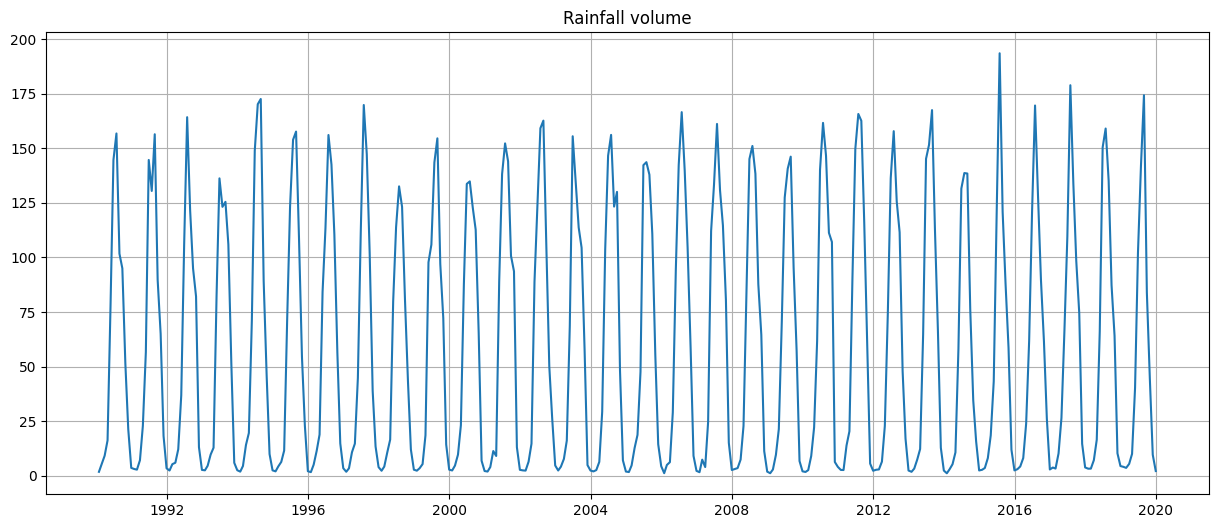

In [109]:
plt.figure(figsize=(15, 6))
plt.plot(df.mean_rainfall)
plt.title('Rainfall volume')
plt.grid(True)
plt.show()

1. `Тренд` не выражен  
2. `Сезонность` есть, осадки сначала растут и достигают максимума, потом падают  
3. `Стационарность` ряд не стационарен (так как есть сезонность)

### Делаем `train/test split`

In [110]:
def timeseries_train_test_split(df, test_size):

    test_index = int(len(df)*(1-test_size))

    df_train = df.iloc[:test_index]
    df_test = df.iloc[test_index:]

    return df_train, df_test

In [111]:
df_train, df_test = timeseries_train_test_split(df, test_size=0.3)

## BaseLine

### Построение с помощью скользящего среднего

In [112]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(df_train, 3)

74.88077777777778

Валидация

In [113]:
df_test.head(1)

,mean_rainfall
date,
2010-12-31,4.079667


### Визуализируем результаты работы модели, произведем замеры качества бейзлайна с релевантной метрикой

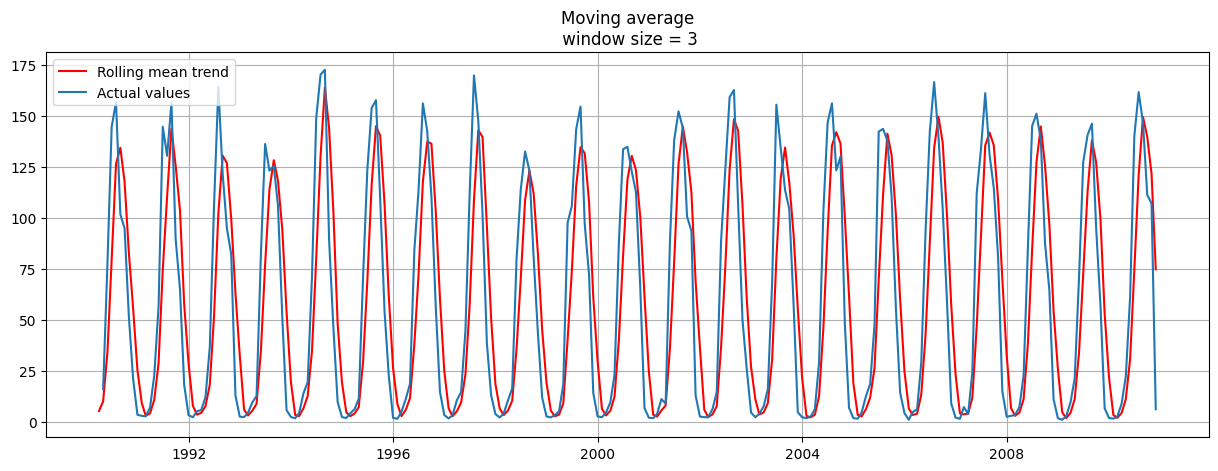

In [114]:
def plotMovingAverage(series, window):

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "r", label="Rolling mean trend")

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

plotMovingAverage(df_train, 3)

Метрикой избрана `MAE`

In [115]:
mean_absolute_error([moving_average(df_train, 3)], df_test.head(1))

70.80111111111111

## Статистическая модель

### Проведем тест Дики-Фуллера и интерпретируем результаты

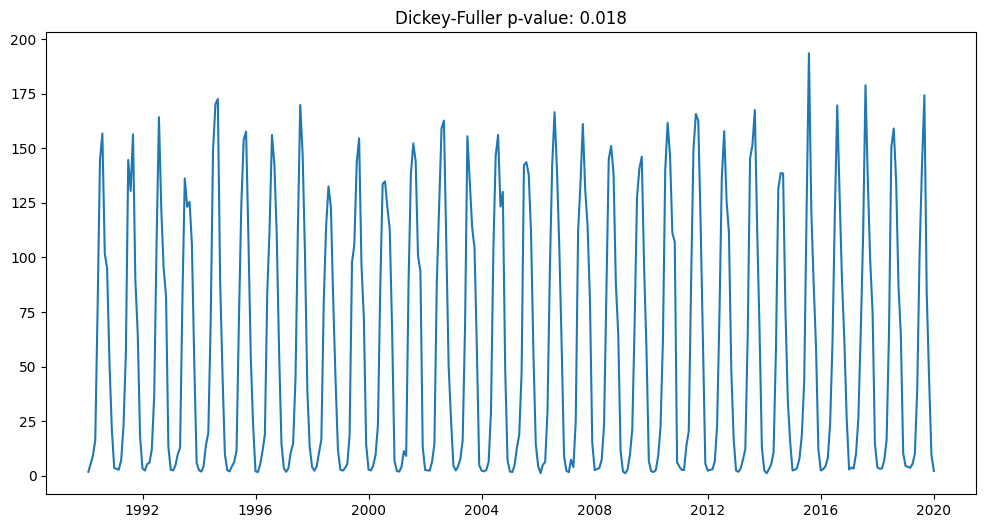

In [116]:
plt.figure(figsize=(12, 6))
plt.plot(df)
plt.title("Dickey-Fuller p-value: {}".format(round(sm.tsa.stattools.adfuller(df_train)[1], 3)))
plt.show()

Тест Дики-Фуллера выдает p-value довольно малый результат, но из этого можно сделать вывод, что ряд стационарен (есть сезонность)

### Построим графики ACF/PACF и проанализируем их, сделаем предположения о наличии/отсутствии сезонности

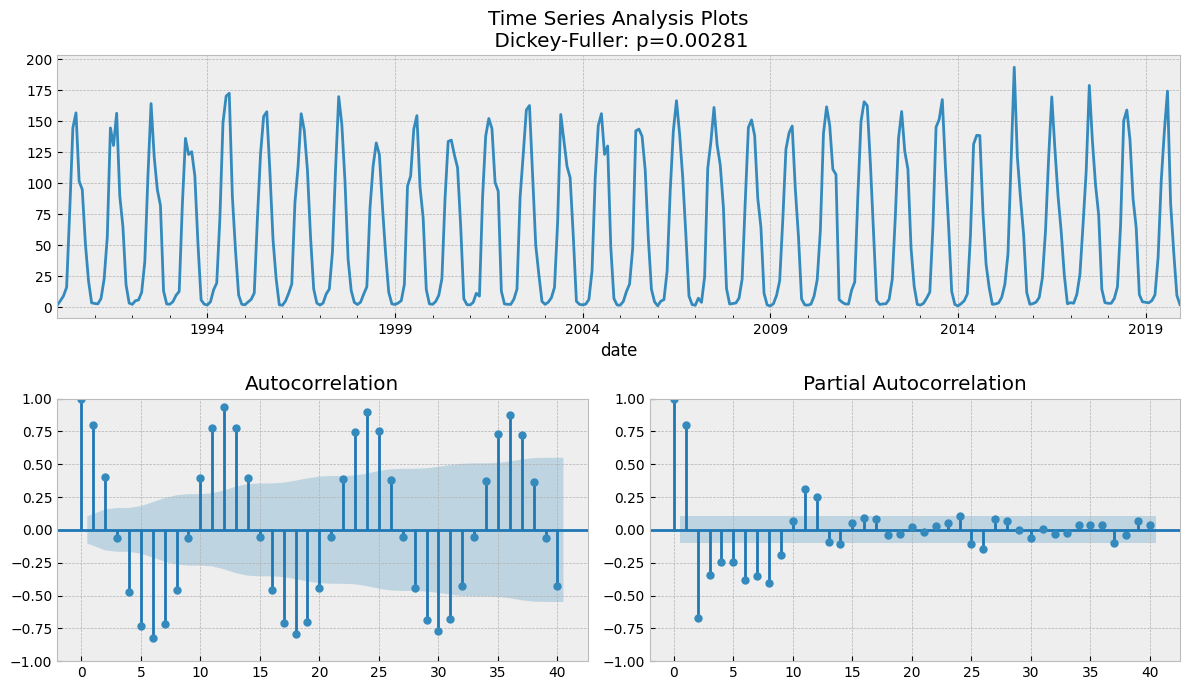

In [117]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

tsplot(df.mean_rainfall, lags=40)

По графику ACF прекрасно наблюдается сезонность продолжительностью 12 лагов - 1 год, следовательно, как и предполагалось в самом начале анализа

### Сезонное дифференцирование

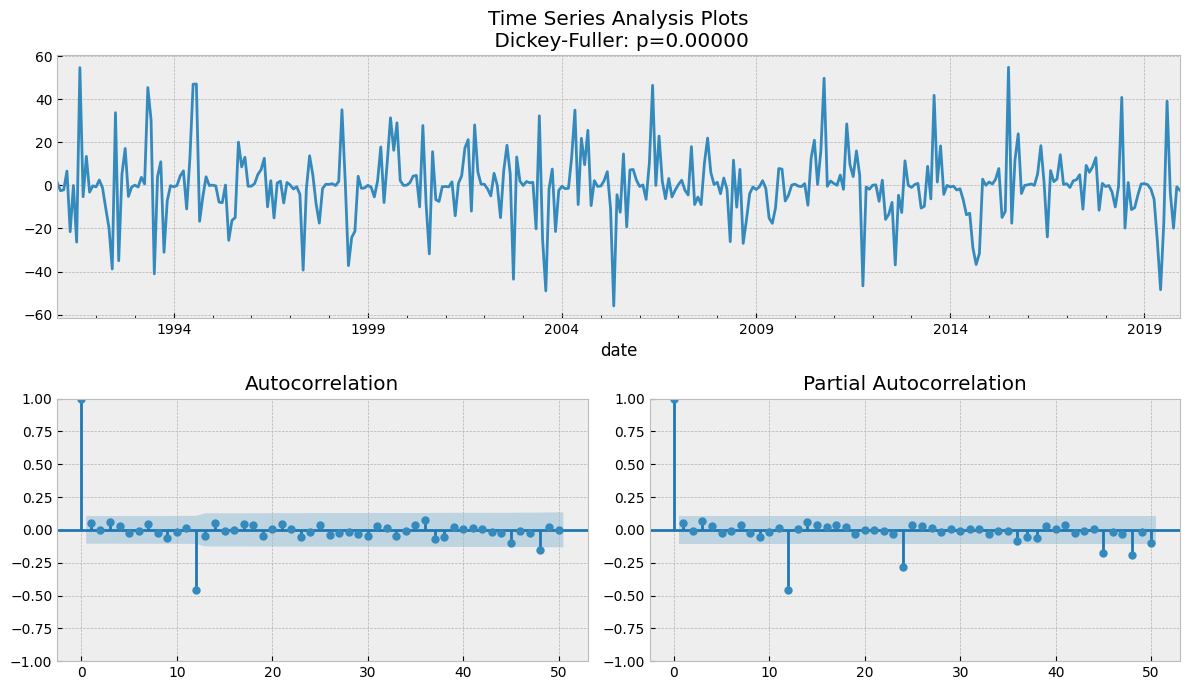

In [118]:
df_diff = df.mean_rainfall - df.mean_rainfall.shift(12)
tsplot(df_diff[12:], lags=50)

Тест Дики-Фуллера показывает, что ряд стационарен, как было и первоначально. После сезонного дифференцирования ряд стал похож на стационарный, однако 12-ый лаг все еще имеет большую корреляцию
(Повторное дифференцирование оставило все без изменения)

### Обучим модель SARIMA для прогнозирования значений ряда, подобрав оптимальные параметры

In [119]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model = sm.tsa.statespace.SARIMAX(df.mean_rainfall, order=(param[0], d, param[1]),
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

Параметры модели:

d = 0 - обычное дифференцирование не проводилось

D = 1 - 1 раз проводилось сезонное дифференцирование

s = 12 - период ряда равен 12-ти измерениям

p = 2 или 3 - из наблюдений PACF

q = 2 или 3 - из наблюдений ACF

P = 1 или 2 - из наблюдений PACF

Q = 2 - из наблюдений ACF

In [120]:
ps = range(2, 4)
d=0
qs = range(2, 4)
Ps = range(0, 2)
D=1
Qs = range(2, 3)
s = 12

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [ ]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

Не сработало (ошибку найти не смогла)

## Классическая модель

### Используем Feature-Engineering для создания признаков

In [122]:
data = pd.DataFrame(df.mean_rainfall.copy())
data.columns = ["y"]

for i in range(1, 37):
    data["lag_{}".format(i)] = data.y.shift(i)

Создадим отдельно признаки дня и месяца

In [123]:
data['day'] = data.index.day
data['month'] = data.index.month

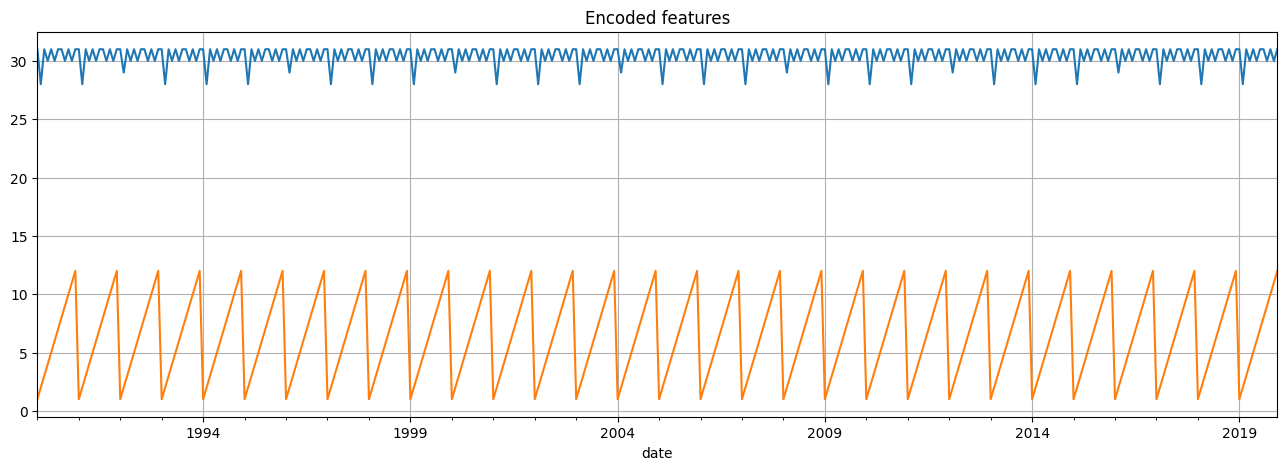

In [124]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data.day.plot()
data.month.plot()
#data.year.plot()
plt.grid(True)

### Обучение модели

In [125]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [126]:
def timeseries_train_test_split(X, y, test_size):

    test_index = int(len(X)*(1-test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [127]:
def plotModelResults(model, X_train=X_train, X_test=X_test):

    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)

In [128]:
from sklearn.ensemble import RandomForestRegressor

In [129]:
regr = RandomForestRegressor(max_depth=6, random_state=42)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, random_state=42)

### Визуализация результатов

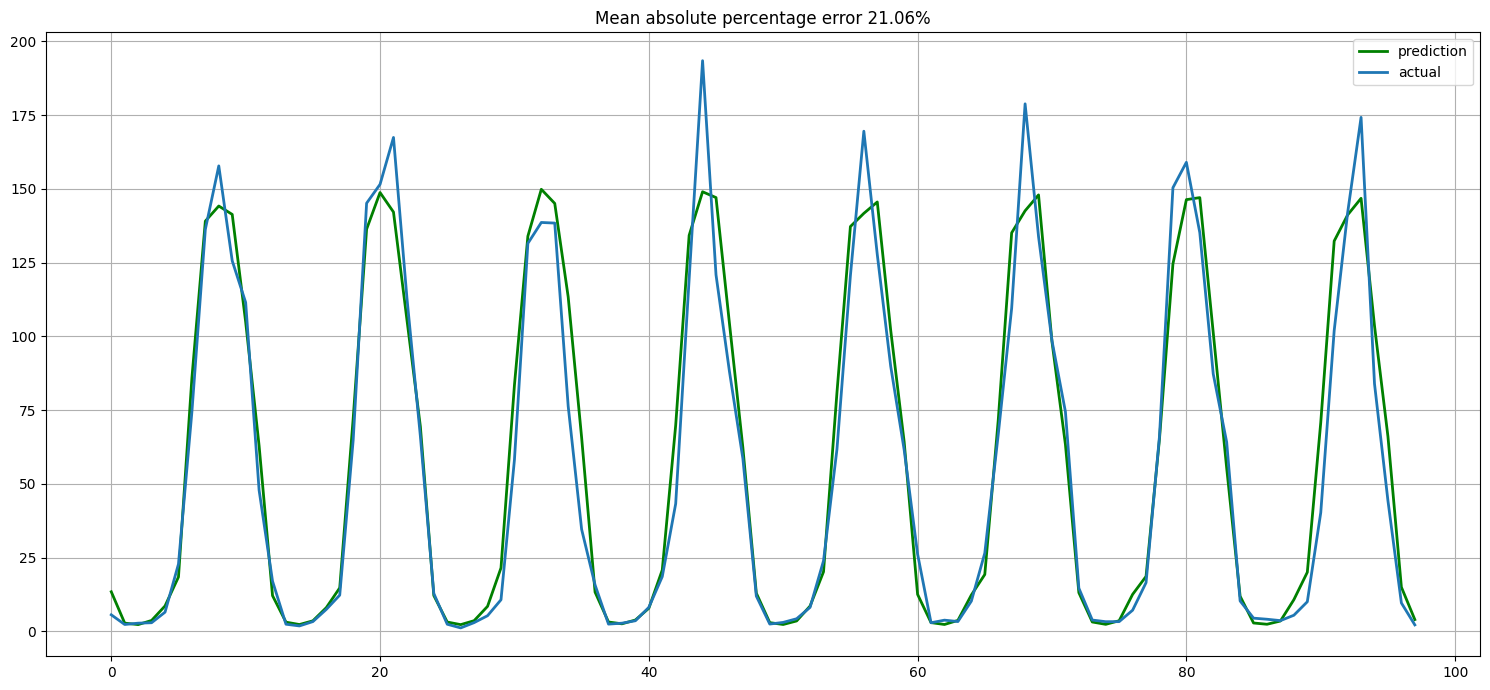

In [130]:
plotModelResults(regr, X_train=X_train, X_test=X_test)

Средняя ошибка модели составляет 21,06%, такая ошибочность модели связана со всплесками в середине каждого года

## Интерпретация

### Permutation importance

In [131]:
%%capture
!pip install -U numpy==1.23.1 shap lime

In [132]:
from sklearn.inspection import permutation_importance
import shap
from lime import lime_tabular

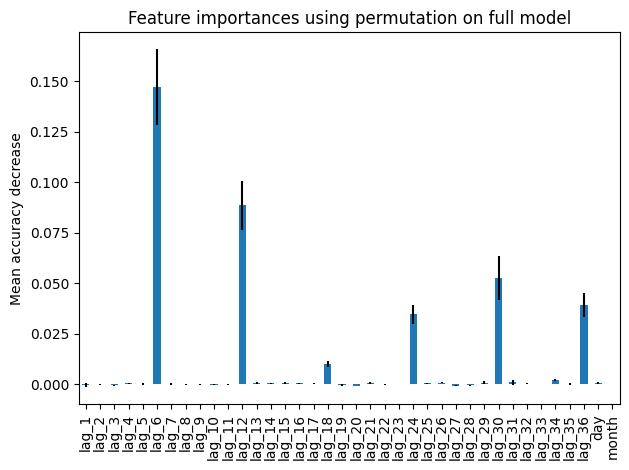

In [133]:
importances = permutation_importance(regr, X_test, y_test, n_repeats=10, random_state=2023, n_jobs=2)
forest_importances = pd.Series(importances.importances_mean, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=importances.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### LIME

In [134]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['rings'],
    verbose=True,
    mode='regression',
)
i = 33
exp = explainer.explain_instance(X_test.iloc[i].values, regr.predict, num_features=5)

Intercept 40.31691544619207
Prediction_local [126.47042365]
Right: 145.07163060270784


Объяснения предсказания модели

In [135]:
exp.show_in_notebook(show_table=True)

In [136]:
exp.as_list()

[('lag_6 <= 4.99', 29.263451637732263),
 ('lag_12 > 112.52', 19.39830843691082),
 ('lag_30 <= 5.14', 13.797018155762343),
 ('lag_36 > 112.01', 11.86125294561817),
 ('lag_24 > 112.52', 11.833477027906092)]

### `SHAP` - локальная интерпретация (для одного объекта)

In [137]:
explainer = shap.TreeExplainer(regr)

choosen_instance = X_test.iloc[[33]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

In [138]:
choosen_instance = X_test.iloc[[27]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

### `SHAP` - глобальная интерпретация (для всей модели целиком)

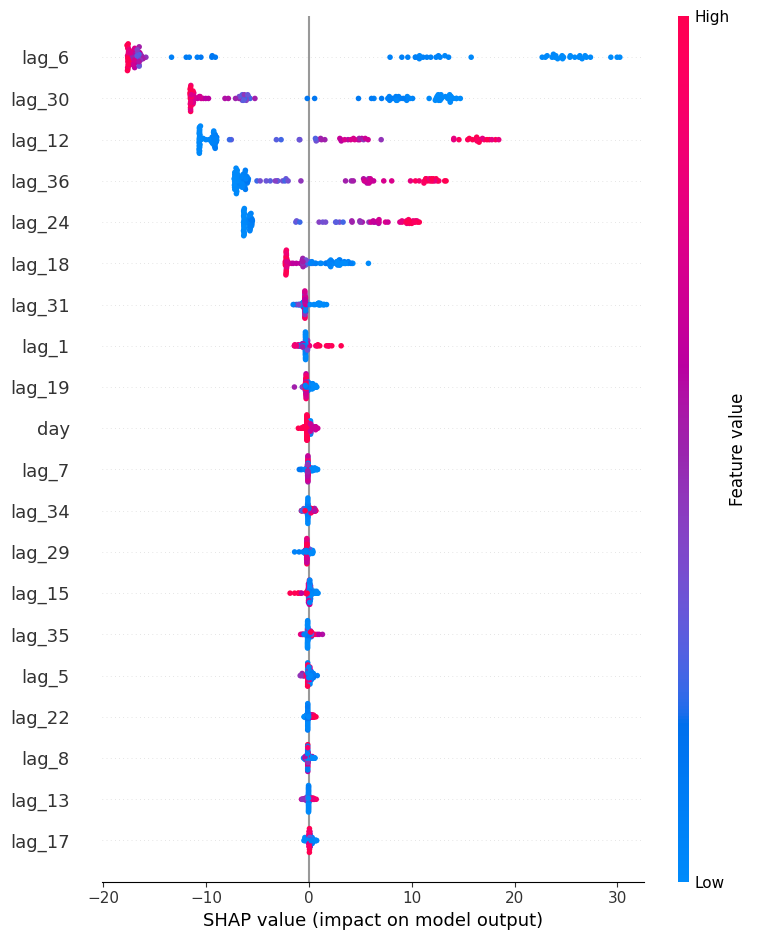

In [139]:
shap_values = explainer.shap_values(X_train.iloc[:100])
shap.summary_plot(shap_values, X_train.iloc[:100])

Судя по результату лаги 6, 12, 30, 36, 24 и 18 представляют большую значимость для анализа по сравнению с остальными